In [26]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define tolerance
tol = 1e-6
# %matplotlib inline
def solution(nDof,fixDof,K,force):
    activeDof = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(activeDof,activeDof)],force[activeDof])
    disp = np.zeros((nDof,1))
    disp[activeDof] = U
    return disp
def shapeFuncQ4(xi,eta):
    shape = np.zeros((4,1))
    shape[:,0] = 1/4*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])
    nderiv = np.zeros((4,2))
    nderiv[0,:] = 1/4*np.array([-(1-eta),-(1-xi)])
    nderiv[1,:] = 1/4*np.array([1-eta,-(1+xi)])
    nderiv[2,:] = 1/4*np.array([1+eta,1+xi])
    nderiv[3,:] = 1/4*np.array([-(1+eta),1-xi])
    return shape, nderiv
def Jacobian(nodeCoord,nderiv):
    J = np.matmul(np.transpose(nodeCoord),nderiv)
    bT = np.transpose(nderiv)
    aT = J.T
    xT = np.linalg.solve(aT,bT)
    xyDeriv = np.transpose(xT)
    return J, xyDeriv
def gaussQuadrature(option):
    if option == 1: # full integration
        locations = np.array([[-0.577350269189626, -0.577350269189626],
                              [0.577350269189626, -0.577350269189626],
                              [0.577350269189626,  0.577350269189626],
                              [-0.577350269189626, 0.577350269189626]])
        weights = np.ones((4,1))
    else:
        locations =np.zeros((1,2))
        weights = 4
    return weights,locations
def formStiffness2D(nDof,nE,eNodes,nP,xy,C,h):
    K = np.zeros((nDof,nDof))
    gaussWt, gaussLoc = gaussQuadrature(1)
    for e in range(nE):
        id = eNodes[e,:]
        eDof = np.zeros((8,1))
        eDof[0:4,0] = id
        eDof[4:8,0] = id + nP
        eDof = eDof.flatten()

        ndof = id.size
        # loop for Gauss point
        for q in range(gaussWt.size):

            GaussPoint = gaussLoc[q,:]
            xi = GaussPoint[0]
            eta = GaussPoint[1]

            # shape functions and derivatives
            shape,nDeriv = shapeFuncQ4(xi,eta)

            # Jacobian matrix, inverse of Jacobian
            J,xyDeriv = Jacobian(xy[id-1,:],nDeriv)

            # B matrix (Linear strain - displacement matrix)
            B = np.zeros((3,2*ndof))
            B[0,0:ndof]      = np.transpose(xyDeriv[:,0])
            B[1,ndof:(2*ndof)] = np.transpose(xyDeriv[:,1])
            B[2,0:ndof]      = np.transpose(xyDeriv[:,1])
            B[2,ndof:(2*ndof)] = np.transpose(xyDeriv[:,0])

            # stiffness matrix
            BT = np.transpose(B)
            detJ = np.linalg.det(J)
            Ke = np.matmul(np.matmul(BT,C),B)*h*detJ*gaussWt[q]
            for ii in range(np.size(Ke,0)):
                row = int(eDof[ii])-1
                for jj in range(np.size(Ke,1)):
                    col = int(eDof[jj])-1
                    K[row,col] = K[row,col] + Ke[ii,jj]
    return K
def PlotMesha(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))

    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi,0]
            Y[i,iel] = xy[ndi,1]

    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()
def PlotMeshb(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))

    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi-1,0]
            Y[i,iel] = xy[ndi-1,1]
E = 2e11
h = 0.01
pois = 0.3
Lx = 1
Ly = 1
E1 =E/(1-pois**2)
C = E1*np.array([[1,     pois,   0],
                 [pois,   1,     0],
                 [0,      0,   (1-pois)/2]])
dfnode = pd.read_csv('NLIST1.csv', header=None)
dfnode.head()
dfnode = dfnode.dropna(axis=0)
dfnode.head()
dfnode1 = dfnode[dfnode[0].isin(["NODE"])]
dfnode = pd.concat([dfnode, dfnode1, dfnode1]).drop_duplicates(keep=False)
dfnode.head()
nP = dfnode.count(axis=0)
nP = nP[0]
nDof = 2*nP
xy = dfnode.iloc[:,1:3]
xy = xy.reset_index()
xy = xy.iloc[:,1:3]
xy = xy.to_numpy(dtype=np.float32)
dfeNode = pd.read_csv('/content/ELIST1.csv', header=None)
dfeNode = dfeNode.dropna(axis=0)
dfeNode = dfeNode[[6,7,8,9]]
eNodes = dfeNode[[6,7,8,9]]
nE = eNodes.count(axis=0)
nE = nE[6]
eNodes.head()
eNodes = eNodes.astype(int)
eNodes = eNodes.to_numpy(dtype=np.int32)
eNodes.shape
PlotMeshb(xy,eNodes,nE)
K = formStiffness2D(nDof,nE,eNodes,nP,xy,C,h)
K.shape
fixP = np.argwhere(xy[:,0]<=tol)
fixDof = np.array([fixP,fixP+nP],order = 'F')
fixDof = fixDof.flatten()
fixDof
dfx = 1e8
dx = 1/20
dy = 1/20
force = np.zeros((nDof,1))
loadP1 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]>=Ly-tol))
loadP2 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]<=tol))
loadP3 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]>=tol) & (xy[:,1]<=Ly-tol))
force[loadP1,0] = dfx*dy/2
force[loadP2,0] = dfx*dy/2
force[loadP3,0] = dfx*dy
disp = solution(nDof,fixDof,K,force)
dispu = disp[0:nP,0]
dispv = disp[nP:2*nP,0]
max(dispu)
max(dispv)
min(dispv)

-0.00776740702019414

In [27]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
def sol(nDof, fixDof, K, force):
    ad = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(ad, ad)], force[ad])
    d = np.zeros((nDof, 1))
    d[ad] = U
    return d
def sf(xi, eta):
    s = np.zeros((4, 1))
    s[:, 0] = 1/4 * np.array([(1 - xi)*(1 - eta), (1 + xi)*(1 - eta), (1 + xi)*(1 + eta), (1 - xi)*(1 + eta)])
    nd = np.zeros((4, 2))
    nd[0, :] = 1/4 * np.array([-(1 - eta), -(1 - xi)])
    nd[1, :] = 1/4 * np.array([1 - eta, -(1 + xi)])
    nd[2, :] = 1/4 * np.array([1 + eta, 1 + xi])
    nd[3, :] = 1/4 * np.array([-(1 + eta), 1 - xi])
    return s, nd
def J(nc, nd):
    j = np.matmul(np.transpose(nc), nd)
    bt = np.transpose(nd)
    at = j.T
    xt = np.linalg.solve(at, bt)
    xyd = np.transpose(xt)
    return j, xyd
def gq(o):
    if o == 1:
        l = np.array([[-0.577350269189626, -0.577350269189626],[0.577350269189626, -0.577350269189626],[0.577350269189626,  0.577350269189626],[-0.577350269189626, 0.577350269189626]])
        w = np.ones((4, 1))
    else:
        l = np.zeros((1, 2))
        w = 4
    return w, l

In [28]:
# -*- coding: utf-8 -*-
"""Untitled80.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1uXpyQRKM1yyJ5BY-NlDbNrUJaUrvD4KA
"""

# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define tolerance
tol = 1e-6
# %matplotlib inline
def solution(nDof,fixDof,K,force):
    activeDof = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(activeDof,activeDof)],force[activeDof])
    disp = np.zeros((nDof,1))
    disp[activeDof] = U
    return disp
def shapeFuncQ4(xi,eta):
    shape = np.zeros((4,1))
    shape[:,0] = 1/4*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])
    nderiv = np.zeros((4,2))
    nderiv[0,:] = 1/4*np.array([-(1-eta),-(1-xi)])
    nderiv[1,:] = 1/4*np.array([1-eta,-(1+xi)])
    nderiv[2,:] = 1/4*np.array([1+eta,1+xi])
    nderiv[3,:] = 1/4*np.array([-(1+eta),1-xi])
    return shape, nderiv
def Jacobian(nodeCoord,nderiv):
    J = np.matmul(np.transpose(nodeCoord),nderiv)
    bT = np.transpose(nderiv)
    aT = J.T
    xT = np.linalg.solve(aT,bT)
    xyDeriv = np.transpose(xT)
    return J, xyDeriv
def gaussQuadrature(option):
    if option == 1: # full integration
        locations = np.array([[-0.577350269189626, -0.577350269189626],
                              [0.577350269189626, -0.577350269189626],
                              [0.577350269189626,  0.577350269189626],
                              [-0.577350269189626, 0.577350269189626]])
        weights = np.ones((4,1))
    else:
        locations =np.zeros((1,2))
        weights = 4
    return weights,locations
def formStiffness2D(nDof,nE,eNodes,nP,xy,C,h):
    K = np.zeros((nDof,nDof))
    gaussWt, gaussLoc = gaussQuadrature(1)
    for e in range(nE):
        id = eNodes[e,:]
        eDof = np.zeros((8,1))
        eDof[0:4,0] = id
        eDof[4:8,0] = id + nP
        eDof = eDof.flatten()

        ndof = id.size
        # loop for Gauss point
        for q in range(gaussWt.size):

            GaussPoint = gaussLoc[q,:]
            xi = GaussPoint[0]
            eta = GaussPoint[1]

            # shape functions and derivatives
            shape,nDeriv = shapeFuncQ4(xi,eta)

            # Jacobian matrix, inverse of Jacobian
            J,xyDeriv = Jacobian(xy[id-1,:],nDeriv)

            # B matrix (Linear strain - displacement matrix)
            B = np.zeros((3,2*ndof))
            B[0,0:ndof]      = np.transpose(xyDeriv[:,0])
            B[1,ndof:(2*ndof)] = np.transpose(xyDeriv[:,1])
            B[2,0:ndof]      = np.transpose(xyDeriv[:,1])
            B[2,ndof:(2*ndof)] = np.transpose(xyDeriv[:,0])

            # stiffness matrix
            BT = np.transpose(B)
            detJ = np.linalg.det(J)
            Ke = np.matmul(np.matmul(BT,C),B)*h*detJ*gaussWt[q]
            for ii in range(np.size(Ke,0)):
                row = int(eDof[ii])-1
                for jj in range(np.size(Ke,1)):
                    col = int(eDof[jj])-1
                    K[row,col] = K[row,col] + Ke[ii,jj]
    return K
def PlotMesha(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))

    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi,0]
            Y[i,iel] = xy[ndi,1]

    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()
def PlotMeshb(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))

    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi-1,0]
            Y[i,iel] = xy[ndi-1,1]
E = 2e11
h = 0.01
pois = 0.3
Lx = 1
Ly = 1
E1 =E/(1-pois**2)
C = E1*np.array([[1,     pois,   0],
                 [pois,   1,     0],
                 [0,      0,   (1-pois)/2]])
dfnode = pd.read_csv('NLIST1.csv', header=None)
dfnode.head()
dfnode = dfnode.dropna(axis=0)
dfnode.head()
dfnode1 = dfnode[dfnode[0].isin(["NODE"])]
dfnode = pd.concat([dfnode, dfnode1, dfnode1]).drop_duplicates(keep=False)
dfnode.head()
nP = dfnode.count(axis=0)
nP = nP[0]
nDof = 2*nP
xy = dfnode.iloc[:,1:3]
xy = xy.reset_index()
xy = xy.iloc[:,1:3]
xy = xy.to_numpy(dtype=np.float32)
dfeNode = pd.read_csv('/content/ELIST1.csv', header=None)
dfeNode = dfeNode.dropna(axis=0)
dfeNode = dfeNode[[6,7,8,9]]
eNodes = dfeNode[[6,7,8,9]]
nE = eNodes.count(axis=0)
nE = nE[6]
eNodes.head()
eNodes = eNodes.astype(int)
eNodes = eNodes.to_numpy(dtype=np.int32)
eNodes.shape
PlotMeshb(xy,eNodes,nE)
K = formStiffness2D(nDof,nE,eNodes,nP,xy,C,h)
K.shape
fixP = np.argwhere(xy[:,0]<=tol)
fixDof = np.array([fixP,fixP+nP],order = 'F')
fixDof = fixDof.flatten()
fixDof
dfx = 1e8
dx = 1/20
dy = 1/20
force = np.zeros((nDof,1))
loadP1 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]>=Ly-tol))
loadP2 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]<=tol))
loadP3 = np.where((xy[:,0]>=Lx-tol) & (xy[:,1]>=tol) & (xy[:,1]<=Ly-tol))
force[loadP1,0] = dfx*dy/2
force[loadP2,0] = dfx*dy/2
force[loadP3,0] = dfx*dy
disp = solution(nDof,fixDof,K,force)
dispu = disp[0:nP,0]
dispv = disp[nP:2*nP,0]
max(dispu)
max(dispv)
min(dispv)

-0.00776740702019414

In [29]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
def sol(nDof, fixDof, K, force):
    ad = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(ad, ad)], force[ad])
    d = np.zeros((nDof, 1))
    d[ad] = U
    return d
def sf(xi, eta):
    s = np.zeros((4, 1))
    s[:, 0] = 1/4 * np.array([(1 - xi)*(1 - eta), (1 + xi)*(1 - eta), (1 + xi)*(1 + eta), (1 - xi)*(1 + eta)])
    nd = np.zeros((4, 2))
    nd[0, :] = 1/4 * np.array([-(1 - eta), -(1 - xi)])
    nd[1, :] = 1/4 * np.array([1 - eta, -(1 + xi)])
    nd[2, :] = 1/4 * np.array([1 + eta, 1 + xi])
    nd[3, :] = 1/4 * np.array([-(1 + eta), 1 - xi])
    return s, nd
def J(nc, nd):
    j = np.matmul(np.transpose(nc), nd)
    bt = np.transpose(nd)
    at = j.T
    xt = np.linalg.solve(at, bt)
    xyd = np.transpose(xt)
    return j, xyd
def gq(o):
    if o == 1:
        l = np.array([[-0.577350269189626, -0.577350269189626],[0.577350269189626, -0.577350269189626],[0.577350269189626,  0.577350269189626],[-0.577350269189626, 0.577350269189626]])
        w = np.ones((4, 1))
    else:
        l = np.zeros((1, 2))
        w = 4
    return w, l


In [30]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

# Define tolerance
tol = 1e-6

def sol(nDof, fixDof, K, force):
    ad = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(ad, ad)], force[ad])
    d = np.zeros((nDof, 1))
    d[ad] = U
    return d

def sf(xi, eta):
    s = np.zeros((4, 1))
    s[:, 0] = 1/4 * np.array([(1 - xi)*(1 - eta), (1 + xi)*(1 - eta), (1 + xi)*(1 + eta), (1 - xi)*(1 + eta)])
    nd = np.zeros((4, 2))
    nd[0, :] = 1/4 * np.array([-(1 - eta), -(1 - xi)])
    nd[1, :] = 1/4 * np.array([1 - eta, -(1 + xi)])
    nd[2, :] = 1/4 * np.array([1 + eta, 1 + xi])
    nd[3, :] = 1/4 * np.array([-(1 + eta), 1 - xi])
    return s, nd

def calculateJacobian(nc, nd):
    j = np.matmul(np.transpose(nc), nd)
    bt = np.transpose(nd)
    at = j.T
    xt = np.linalg.solve(at, bt)
    xyd = np.transpose(xt)
    return j, xyd

def gq(o):
    if o == 1:
        l = np.array([[-0.577350269189626, -0.577350269189626],[0.577350269189626, -0.577350269189626],[0.577350269189626,  0.577350269189626],[-0.577350269189626, 0.577350269189626]])
        w = np.ones((4, 1))
    else:
        l = np.zeros((1, 2))
        w = 4
    return w, l

def formStiffness2D(nDof, nE, eNodes, nP, xy, C, h):
    K = np.zeros((nDof, nDof))
    gaussWt, gaussLoc = gq(1)
    for e in range(nE):
        id = eNodes[e, :]
        eDof = np.zeros((8, 1))
        eDof[0:4, 0] = id
        eDof[4:8, 0] = id + nP
        eDof = eDof.flatten()

        ndof = id.size
        # loop for Gauss point
        for q in range(gaussWt.size):

            GaussPoint = gaussLoc[q, :]
            xi = GaussPoint[0]
            eta = GaussPoint[1]

            # shape functions and derivatives
            shape, nDeriv = sf(xi, eta)

            # Jacobian matrix, inverse of Jacobian
            jacobian, xyDeriv = calculateJacobian(xy[id - 1, :], nDeriv)

            # B matrix (Linear strain - displacement matrix)
            B = np.zeros((3, 2 * ndof))
            B[0, 0:ndof] = np.transpose(xyDeriv[:, 0])
            B[1, ndof:(2 * ndof)] = np.transpose(xyDeriv[:, 1])
            B[2, 0:ndof] = np.transpose(xyDeriv[:, 1])
            B[2, ndof:(2 * ndof)] = np.transpose(xyDeriv[:, 0])

            # stiffness matrix
            BT = np.transpose(B)
            detJ = np.linalg.det(jacobian)
            Ke = np.matmul(np.matmul(BT, C), B) * h * detJ * gaussWt[q]
            for ii in range(np.size(Ke, 0)):
                row = int(eDof[ii]) - 1
                for jj in range(np.size(Ke, 1)):
                    col = int(eDof[jj]) - 1
                    K[row, col] = K[row, col] + Ke[ii, jj]
    return K

def plot_sparse_matrix(matrix):
    plt.figure(figsize=(8, 8))
    plt.spy(matrix, markersize=1)
    plt.title("Sparse Matrix Visualization")
    plt.show()

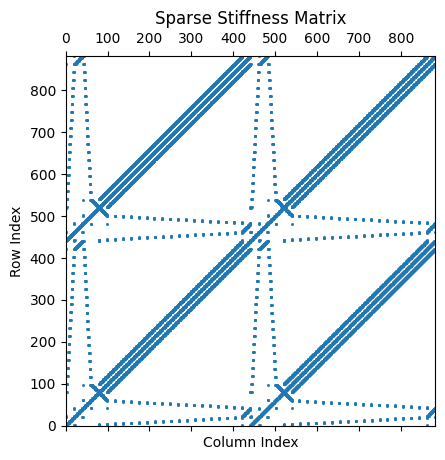

In [39]:
# Calculate stiffness matrix
K = formStiffness2D(nDof, nE, eNodes, nP, xy, C, h)

# Convert stiffness matrix to a sparse matrix
sparse_K = coo_matrix(K)

# Define a function to plot sparse matrix
def plot_sparse_matrix(sparse_matrix):
    plt.spy(sparse_matrix, markersize=1)
    plt.title('Sparse Stiffness Matrix')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')

    # Set custom axis ranges (adjust these values as needed)
    plt.xlim(0, sparse_matrix.shape[1])  # Range for x axis (columns)
    plt.ylim(0, sparse_matrix.shape[0])  # Range for y axis (rows)

    plt.show()

# Plot the sparse matrix
plot_sparse_matrix(sparse_K)